In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from VAE import VAE

import scanpy as sc

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.optim import lr_scheduler

### Binary MNIST

In [49]:
# binary MNIST
dataset = MNIST('../data/', train=True, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x)), T.Lambda(lambda x: (x>0.5).float())]))

trainloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vae = VAE(n_features=784, z_dim=16, layer_sizes=[256,128], generative_model='bernoulli', kl_weight=1e-6, is_autoregressive=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=)

In [50]:
for epoch in range(10):
    epoch_loss_list = []
    for x, label in trainloader:
        vae.decoder.update_autoregressive_mask()
        optimizer.zero_grad()

        _, _, loss = vae.forward(x)

        loss.backward()
        epoch_loss_list.append(loss.detach())

        optimizer.step()

    print(f'Epoch {epoch+1} mean loss: {np.mean(epoch_loss_list):.3f}')

Epoch 1 mean loss: 0.16380825638771057
Epoch 2 mean loss: 0.10084163397550583
Epoch 3 mean loss: 0.08665381371974945
Epoch 4 mean loss: 0.07876148819923401
Epoch 5 mean loss: 0.073893703520298
Epoch 6 mean loss: 0.07076480984687805
Epoch 7 mean loss: 0.06847880780696869
Epoch 8 mean loss: 0.06669384986162186
Epoch 9 mean loss: 0.06521571427583694
Epoch 10 mean loss: 0.06401894986629486


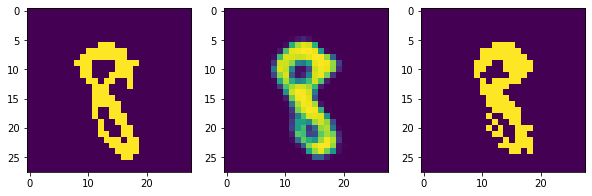

In [51]:
for x, label in trainloader:
    f, ax = plt.subplots(ncols=3, figsize=(10,6))
    ax[0].imshow(x[0].detach().reshape(-1,28,28)[0])
    out = vae(x)
    ax[1].imshow(out[1][0].detach().reshape(-1,28,28)[0])
    ax[2].imshow(out[0][0].detach().reshape(-1,28,28)[0])
    plt.show()
    break

In [52]:
X = dataset.data.reshape(-1,784).float()

labels = dataset.targets

In [53]:
_ = vae.forward(X)

<AxesSubplot: >

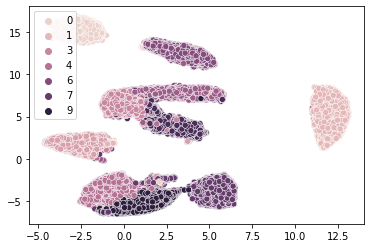

In [54]:
import umap
import seaborn as sns

reducer = umap.UMAP()

z_umap = reducer.fit_transform(vae.z.detach())

sns.scatterplot(x=z_umap[:,0], y=z_umap[:,1], hue=labels)

### Binary gene expression data

In [55]:
data = sc.read_10x_h5('/Users/liam/OneDrive - McGill University/scRNA/data/10x_Genomics_Datasets/pbmc_10k_v3_filtered_feature_bc_matrix.h5')
sc.pp.filter_genes(data, min_cells=3)
sc.pp.log1p(data)
n_genes = 2000
sc.pp.highly_variable_genes(data, n_top_genes=n_genes)
data = data[:,data.var['highly_variable']]

/Users/liam/opt/anaconda3/envs/torch-mps1/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/liam/opt/anaconda3/envs/torch-mps1/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [56]:
# binary single cell data
X = torch.Tensor((data.X.toarray()>0).astype(int)).float()
trainloader = DataLoader(X, batch_size=128, shuffle=True, drop_last=True)

vae = VAE(n_features=n_genes, z_dim=64, layer_sizes=[128,128], generative_model='bernoulli', kl_weight=1e-6, is_autoregressive=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [57]:
for epoch in range(20):
    epoch_loss_list = []
    for x in trainloader:
        vae.decoder.update_autoregressive_mask()
        optimizer.zero_grad()

        _, _, loss = vae.forward(x)

        loss.backward()
        epoch_loss_list.append(loss.detach())

        optimizer.step()

    print(f'Epoch {epoch+1} mean loss: {np.mean(epoch_loss_list):.3f}')

Epoch 1 mean loss: 0.317
Epoch 2 mean loss: 0.209
Epoch 3 mean loss: 0.198
Epoch 4 mean loss: 0.192
Epoch 5 mean loss: 0.189
Epoch 6 mean loss: 0.187
Epoch 7 mean loss: 0.186
Epoch 8 mean loss: 0.185
Epoch 9 mean loss: 0.184
Epoch 10 mean loss: 0.183
Epoch 11 mean loss: 0.182
Epoch 12 mean loss: 0.182
Epoch 13 mean loss: 0.181
Epoch 14 mean loss: 0.180
Epoch 15 mean loss: 0.180
Epoch 16 mean loss: 0.180
Epoch 17 mean loss: 0.179
Epoch 18 mean loss: 0.179
Epoch 19 mean loss: 0.179
Epoch 20 mean loss: 0.178


In [58]:
_ = vae.forward(X)

data_latent = sc.AnnData(X=vae.z.detach().numpy(), obs=data.obs)

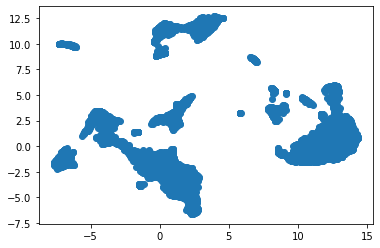

In [59]:
import umap

reducer = umap.UMAP()

z_umap = reducer.fit_transform(vae.z.detach())

plt.scatter(z_umap[:,0], z_umap[:,1])